In [1]:
import os
import urllib.request
import re


if not os.path.exists("the-verdict"):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch02/01_main-chapter-code/the-verdict.txt", 
                   "the-verdict")

In [2]:
with open("the-verdict", "r", encoding = "utf-8") as f:
    raw_text = f.read()

len(raw_text)

20479

In [3]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
preprocessed[:20]

['I',
 'HAD',
 'always',
 'thought',
 'Jack',
 'Gisburn',
 'rather',
 'a',
 'cheap',
 'genius',
 '--',
 'though',
 'a',
 'good',
 'fellow',
 'enough',
 '--',
 'so',
 'it',
 'was']

In [4]:
len(preprocessed)

4690

In [5]:
# tokens to token ids

all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
vocab_size

1130

In [6]:
vocab = {word: token for token, word in enumerate(all_words)}
vocab

{'!': 0,
 '"': 1,
 "'": 2,
 '(': 3,
 ')': 4,
 ',': 5,
 '--': 6,
 '.': 7,
 ':': 8,
 ';': 9,
 '?': 10,
 'A': 11,
 'Ah': 12,
 'Among': 13,
 'And': 14,
 'Are': 15,
 'Arrt': 16,
 'As': 17,
 'At': 18,
 'Be': 19,
 'Begin': 20,
 'Burlington': 21,
 'But': 22,
 'By': 23,
 'Carlo': 24,
 'Chicago': 25,
 'Claude': 26,
 'Come': 27,
 'Croft': 28,
 'Destroyed': 29,
 'Devonshire': 30,
 'Don': 31,
 'Dubarry': 32,
 'Emperors': 33,
 'Florence': 34,
 'For': 35,
 'Gallery': 36,
 'Gideon': 37,
 'Gisburn': 38,
 'Gisburns': 39,
 'Grafton': 40,
 'Greek': 41,
 'Grindle': 42,
 'Grindles': 43,
 'HAD': 44,
 'Had': 45,
 'Hang': 46,
 'Has': 47,
 'He': 48,
 'Her': 49,
 'Hermia': 50,
 'His': 51,
 'How': 52,
 'I': 53,
 'If': 54,
 'In': 55,
 'It': 56,
 'Jack': 57,
 'Jove': 58,
 'Just': 59,
 'Lord': 60,
 'Made': 61,
 'Miss': 62,
 'Money': 63,
 'Monte': 64,
 'Moon-dancers': 65,
 'Mr': 66,
 'Mrs': 67,
 'My': 68,
 'Never': 69,
 'No': 70,
 'Now': 71,
 'Nutley': 72,
 'Of': 73,
 'Oh': 74,
 'On': 75,
 'Once': 76,
 'Only': 77,
 '

In [7]:
all_words = sorted(list(set(preprocessed)))
all_words.extend(["<|endoftext|>", "<|unk|>"])
vocab = {word: token for token, word in enumerate(all_words)}
vocab_size = len(all_words)
vocab_size

1132

In [8]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_2_int = vocab
        self.int_2_str = {token: word for word, token in vocab.items()}

    def encode(self, text: str):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [
            item if item in self.str_2_int
            else "<|unk|>"
            for item in preprocessed
            ]

        ids = [self.str_2_int[s] for s in preprocessed]
        return ids

    def decoder(self, ids: list):
        text = ' '.join([self.int_2_str[s] for s in ids])
        text = re.sub(r"\s+([,.?!\"'])", r"\1", text)
        return text

tokenozer_v1 = SimpleTokenizerV1(vocab)
text = "hello."
encoded = tokenozer_v1.encode(text)
decoded = tokenozer_v1.decoder(encoded)

print(f"text: {text}")
print(f"encoded: {encoded}")
print(f"decoded: {decoded}")

text: hello.
encoded: [1131, 7, 1131]
decoded: <|unk|>. <|unk|>


In [9]:
# tiktoken
import tiktoken

tokenizer_tik = tiktoken.get_encoding("gpt2")

In [10]:
vocab_size = tokenizer_tik.n_vocab
vocab_size

50257

In [11]:
h = tokenizer_tik.encode(
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.",
    allowed_special={"<|endoftext|>"}
)

decoded = tokenizer_tik.decode(h)
decoded

'Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.'

In [12]:
import torch
from torch.utils.data import DataLoader, Dataset

In [13]:
class GPT_Dataset_V1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        super().__init__()

        self.input_ids  = []
        self.target_ids = []

        self.token_ids = h = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

        for i in range(0, len(self.token_ids) - max_length, stride):
            self.input_ids.append(
                torch.tensor(self.token_ids[i:i + max_length])
            )

            self.target_ids.append(
                torch.tensor(self.token_ids[i + 1: i + max_length + 1])
            )
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
    
gpt_ds_v1 = GPT_Dataset_V1(raw_text, tokenizer_tik, 5, 10)

sample_inputs, sample_targets = next(iter(gpt_ds_v1))
print(tokenizer_tik.decode(sample_inputs.tolist()))
print(tokenizer_tik.decode(sample_targets.tolist()))


I HAD always thought
 HAD always thought Jack


In [14]:
def create_dataloader(text, batch_size = 2, max_length = 256, stride = 128, shuffle = True, drop_last = True, num_workers = 4):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPT_Dataset_V1(text, tokenizer, max_length, stride)
    # print(type(max_length), type(stride), type(text))
    
    dataloader = DataLoader(
        dataset, 
        batch_size = batch_size, 
        shuffle = shuffle, 
        drop_last = drop_last, 
        num_workers = num_workers)
    
    return dataloader

In [15]:
sample_inputs, sample_targets = next(iter(create_dataloader(raw_text, max_length = 10, num_workers = 0, batch_size = 8)))
sample_inputs

tensor([[22645,    11,   465, 10904,  4252,  6236,   429, 25839,  9230,   808],
        [  673,  1908,   329,   345,  1701,   198,   198,     1,  5297,   438],
        [   13,   198,   198,     1, 19242,   339,   442, 17758,   465,  5986],
        [10197,   832,   262, 46475,   286, 18113,   544,   338, 10953,   314],
        [  286,  1762,    30,  2011, 29483,  2540,   284,   467,   257,  1310],
        [  503,  4291,   262,  4252, 18250,  8812,   558,    13,   198,   198],
        [   11,   508,   550, 18459,  1068,   284,  1577,   257, 23844,   286],
        [  314,   550,  1775,   683,    11,   523,  1690,    11,  1615,  3364]])

In [16]:
sample_targets

tensor([[   11,   465, 10904,  4252,  6236,   429, 25839,  9230,   808,   276],
        [ 1908,   329,   345,  1701,   198,   198,     1,  5297,   438, 37121],
        [  198,   198,     1, 19242,   339,   442, 17758,   465,  5986,  1165],
        [  832,   262, 46475,   286, 18113,   544,   338, 10953,   314,  2936],
        [ 1762,    30,  2011, 29483,  2540,   284,   467,   257,  1310,  4295],
        [ 4291,   262,  4252, 18250,  8812,   558,    13,   198,   198,    40],
        [  508,   550, 18459,  1068,   284,  1577,   257, 23844,   286,  7543],
        [  550,  1775,   683,    11,   523,  1690,    11,  1615,  3364,   739]])

In [17]:
s = torch.nn.Embedding(5, 2)
s.weight

Parameter containing:
tensor([[-0.5642,  0.5990],
        [-0.2319,  0.4780],
        [-0.1385,  0.7457],
        [ 1.4079, -1.3485],
        [-1.0899,  0.4179]], requires_grad=True)

In [18]:
s(torch.tensor([2,3]))

tensor([[-0.1385,  0.7457],
        [ 1.4079, -1.3485]], grad_fn=<EmbeddingBackward0>)

In [19]:
# embeddings
batch_size = 8
max_length = 4

inputs, targets = next(iter(create_dataloader(raw_text, max_length = max_length, stride = max_length, num_workers = 0, batch_size = batch_size, shuffle=False)))
inputs

tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

In [20]:
inputs.shape

torch.Size([8, 4])

In [21]:
vocab_size = tokenizer_tik.n_vocab # 50257
output_dim = 256

embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
embedding_layer.weight

Parameter containing:
tensor([[-0.8336, -0.4853,  0.1686,  ..., -0.8441, -2.2126, -1.4050],
        [-1.3394, -1.3918, -1.2637,  ...,  0.5155, -2.2150,  0.1518],
        [ 1.0084,  1.0645, -0.5048,  ..., -1.2112, -0.5159, -1.1095],
        ...,
        [ 0.5208, -0.7041, -0.8828,  ..., -0.2291, -1.4264, -0.5446],
        [ 0.2630, -0.6460, -1.0120,  ..., -0.5210,  2.1854,  0.5296],
        [ 0.0591, -1.7492,  0.7280,  ..., -0.6397,  1.7635,  0.3991]],
       requires_grad=True)

In [22]:
embedding_layer.weight.shape

torch.Size([50257, 256])

In [23]:
token_embedding = embedding_layer(inputs)
token_embedding.shape

torch.Size([8, 4, 256])

In [24]:
position_embedding_layer = torch.nn.Embedding(max_length, output_dim)
position_embedding_layer.weight.shape

torch.Size([4, 256])

In [25]:
pos_embedding = position_embedding_layer(torch.arange(max_length))
pos_embedding.shape

torch.Size([4, 256])

In [26]:
input_embedding = token_embedding + pos_embedding
input_embedding.shape

torch.Size([8, 4, 256])

In [27]:
# Attention mechanics without trainable weights
inputs = torch.tensor([
    [0.43, 0.15, 0.89],   # Your    (x^1)
    [0.55, 0.87, 0.66],   # journey (x^2)
    [0.57, 0.85, 0.64],   # starts  (x^3)
    [0.22, 0.58, 0.33],   # with    (x^4)
    [0.77, 0.25, 0.10],   # one     (x^5)
    [0.05, 0.80, 0.55],   # step    (x^6)
])

In [28]:
attn_weights = torch.softmax(inputs @ inputs.T, dim = 1)
attn_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [29]:
context_vectors = attn_weights @ inputs
context_vectors

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

In [30]:
# Attention mechanics with trainable weights

d_in = inputs.shape[1] # 3
d_out = 2

torch.manual_seed(123)

W_key   = torch.nn.Parameter(torch.rand(d_in, d_out))
W_query = torch.nn.Parameter(torch.rand(d_in, d_out))
W_value = torch.nn.Parameter(torch.rand(d_in, d_out))

keys = inputs @ W_key
queries = inputs @ W_query
values = inputs @ W_value

In [31]:
attn_score = queries @ keys.T
attn_score

tensor([[0.9231, 1.2705, 1.2544, 0.6973, 0.6114, 0.8995],
        [1.3545, 1.8524, 1.8284, 1.0167, 0.8819, 1.3165],
        [1.3241, 1.8111, 1.7877, 0.9941, 0.8626, 1.2871],
        [0.7910, 1.0795, 1.0654, 0.5925, 0.5121, 0.7682],
        [0.4032, 0.5577, 0.5508, 0.3061, 0.2707, 0.3937],
        [1.1330, 1.5440, 1.5238, 0.8475, 0.7307, 1.0996]],
       grad_fn=<MmBackward0>)

In [32]:
attn_weights = torch.softmax(attn_score / d_out**0.5, dim = 1)
attn_weights

tensor([[0.1618, 0.2068, 0.2045, 0.1379, 0.1298, 0.1591],
        [0.1588, 0.2258, 0.2220, 0.1251, 0.1137, 0.1546],
        [0.1591, 0.2245, 0.2208, 0.1260, 0.1148, 0.1550],
        [0.1635, 0.2006, 0.1986, 0.1421, 0.1343, 0.1609],
        [0.1649, 0.1840, 0.1831, 0.1540, 0.1502, 0.1638],
        [0.1612, 0.2156, 0.2126, 0.1318, 0.1213, 0.1575]],
       grad_fn=<SoftmaxBackward0>)

In [33]:
context_vectors = attn_weights @ values
context_vectors

tensor([[0.2947, 0.7956],
        [0.3015, 0.8132],
        [0.3010, 0.8120],
        [0.2925, 0.7902],
        [0.2863, 0.7737],
        [0.2979, 0.8043]], grad_fn=<MmBackward0>)

In [34]:
class Self_attention_v1(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()

        self.d_out     = d_out
        self.W_keys    = torch.nn.Linear(d_in, d_out)
        self.W_queries = torch.nn.Linear(d_in, d_out)
        self.W_values  = torch.nn.Linear(d_in, d_out)


    def forward(self, inputs):
        
        querys = self.W_queries(inputs)
        keys   = self.W_keys(inputs)
        values = self.W_values(inputs)

        attn_scores = querys @ keys.T
        attn_weights = torch.softmax(attn_scores / self.d_out**0.5, dim = 1)
        context_vectors = attn_weights @ values

        return context_vectors

torch.manual_seed(5)

sa = Self_attention_v1(3, 2)
sa(inputs)

tensor([[-0.4562,  0.5104],
        [-0.4659,  0.5034],
        [-0.4656,  0.5036],
        [-0.4644,  0.5045],
        [-0.4590,  0.5080],
        [-0.4676,  0.5023]], grad_fn=<MmBackward0>)

In [35]:
querys = sa.W_queries(inputs)
keys   = sa.W_keys(inputs)
values = sa.W_values(inputs)

attn_scores = querys @ keys.T
attn_weights = torch.softmax(attn_scores / sa.d_out**0.5, dim = 1)

masked_attn_weights = torch.tril(torch.ones(attn_weights.shape[0], attn_weights.shape[0])) * attn_weights # doesnt sum up to one
masked_attn_weights

tensor([[0.1662, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1987, 0.1625, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1971, 0.1627, 0.1630, 0.0000, 0.0000, 0.0000],
        [0.1945, 0.1635, 0.1638, 0.1562, 0.0000, 0.0000],
        [0.1643, 0.1673, 0.1674, 0.1669, 0.1674, 0.0000],
        [0.2104, 0.1612, 0.1616, 0.1509, 0.1682, 0.1476]],
       grad_fn=<MulBackward0>)

In [36]:
masked_simple_norm = masked_attn_weights / masked_attn_weights.sum(dim=1, keepdim=True) # sum up to one
masked_simple_norm

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5501, 0.4499, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3771, 0.3112, 0.3117, 0.0000, 0.0000, 0.0000],
        [0.2868, 0.2411, 0.2416, 0.2304, 0.0000, 0.0000],
        [0.1971, 0.2008, 0.2008, 0.2004, 0.2008, 0.0000],
        [0.2104, 0.1612, 0.1616, 0.1509, 0.1682, 0.1476]],
       grad_fn=<DivBackward0>)

In [37]:
# Simpler approach
attn_scores

tensor([[ 0.0516,  0.0783,  0.0812,  0.0205,  0.1030, -0.0028],
        [ 0.0493, -0.2352, -0.2328, -0.2973, -0.1936, -0.3178],
        [ 0.0470, -0.2246, -0.2222, -0.2837, -0.1849, -0.3032],
        [ 0.0522, -0.1932, -0.1906, -0.2577, -0.1524, -0.2796],
        [ 0.0034,  0.0296,  0.0298,  0.0263,  0.0298,  0.0246],
        [ 0.0749, -0.3017, -0.2978, -0.3948, -0.2416, -0.4261]],
       grad_fn=<MmBackward0>)

In [38]:
d_out

2

In [39]:
mask = torch.triu(torch.ones(attn_weights.shape[0], attn_weights.shape[0]), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), - torch.inf)
attn_weights = torch.softmax(masked / d_out**0.5, dim=1)
layer_dropout = torch.nn.Dropout(0.5)
attn_weights = layer_dropout(attn_weights)
attn_weights

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6224, 0.6234, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4832, 0.4608, 0.0000, 0.0000],
        [0.3943, 0.0000, 0.4017, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3364, 0.2953]],
       grad_fn=<MulBackward0>)

In [40]:
attn_weights.sum(1, keepdim=True)

tensor([[0.0000],
        [0.0000],
        [1.2458],
        [0.9440],
        [0.7960],
        [0.6316]], grad_fn=<SumBackward1>)

In [41]:
class Causal_attention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False):
        super().__init__()

        self.d_out     = d_out
        self.W_keys    = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_queries = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_values  = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.dropout   = torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, inputs):
        batch, num_tokens, d_in = inputs.shape
        querys = self.W_queries(inputs)
        keys   = self.W_keys(inputs)
        values = self.W_values(inputs)

        attn_scores = querys @ keys.transpose(1,2)
        attn_scores = attn_scores.masked_fill(self.mask.bool()[:num_tokens, :num_tokens], - torch.inf)
        attn_weights = torch.softmax(attn_scores / self.d_out**0.5, dim = 1)
        attn_weights = self.dropout(attn_weights)
        context_vectors = attn_weights @ values
        return context_vectors

torch.manual_seed(5)
if len(inputs.shape) != 3: inputs = torch.stack((inputs, inputs))
ca = Causal_attention(3, 2, context_length = 6, dropout = 0.0)
ca(inputs).shape

torch.Size([2, 6, 2])

In [42]:
inputs.shape

torch.Size([2, 6, 3])

In [43]:
class Multihead_Attention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False, num_heads = 2):
        super().__init__()
        self.heads = torch.nn.ModuleList(
                        [Causal_attention(d_in, d_out, context_length = context_length, dropout = dropout) for _ in range(num_heads)
                    ])
    def forward(self, inputs):
        return torch.cat([head(inputs) for head in self.heads], dim = -1)
    
ma = Multihead_Attention(3, 2, context_length = 6, dropout = 0.0, qkv_bias=False, num_heads=2)
ma(inputs).shape

torch.Size([2, 6, 4])

In [44]:
ma(inputs)

tensor([[[-0.1135,  0.0497,  0.0944, -0.0486],
         [-0.2730,  0.1452,  0.1812, -0.1157],
         [-0.4732,  0.2627,  0.2877, -0.1968],
         [-0.6024,  0.3529,  0.3261, -0.2437],
         [-0.8042,  0.4074,  0.4937, -0.3022],
         [-1.3560,  0.8358,  0.6603, -0.5475]],

        [[-0.1135,  0.0497,  0.0944, -0.0486],
         [-0.2730,  0.1452,  0.1812, -0.1157],
         [-0.4732,  0.2627,  0.2877, -0.1968],
         [-0.6024,  0.3529,  0.3261, -0.2437],
         [-0.8042,  0.4074,  0.4937, -0.3022],
         [-1.3560,  0.8358,  0.6603, -0.5475]]], grad_fn=<CatBackward0>)

In [45]:
class MutliHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False, num_heads = 2):
        super().__init__()  

        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"


        self.d_out     = d_out
        self.num_heads = num_heads
        self.head_dim  = d_out // num_heads

        self.W_keys    = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_queries = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_values  = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        
        self.out_proj  = torch.nn.Linear(d_out, d_out) 
        self.dropout   = torch.nn.Dropout(dropout)
        
        self.register_buffer("mask", 
                             torch.triu(torch.ones(context_length, context_length), diagonal=1)
                             )
        # print(d_out)
    def forward(self, inputs):
        batch, num_tokens, d_in = inputs.shape
        
        keys   = self.W_keys(inputs)
        querys = self.W_queries(inputs)
        values = self.W_values(inputs)

        # Splitting
        # (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys   = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        querys = querys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)


        keys   = keys.transpose(1,2)   # (batch, num_tokens, num_heads, head_dim) -> (batch, num_heads, num_tokens, head_dim)
        querys = querys.transpose(1,2) # (batch, num_tokens, num_heads, head_dim) -> (batch, num_heads, num_tokens, head_dim)
        values = values.transpose(1,2) # (batch, num_tokens, num_heads, head_dim) -> (batch, num_heads, num_tokens, head_dim)


        attn_scores = querys @ keys.transpose(2,3)                  # self attention
        attn_scores.masked_fill_(                   
            self.mask.bool()[:num_tokens, :num_tokens], - torch.inf # Causal attention
            )
        
        attn_weights = torch.softmax(attn_scores / self.d_out**0.5, dim = -1) # Normalizing
        attn_weights = self.dropout(attn_weights)
        context_vectors = (attn_weights @ values).transpose(1,2) # (batch, num_heads, num_tokens, head_dim) -> (batch, num_tokens, num_heads, head_dim)
        context_vectors = context_vectors.contiguous().view(batch, num_tokens, self.d_out) # Combining it back to a concatinated form

        return context_vectors
    
mha = MutliHeadAttention(d_in = 3, d_out = 3, context_length = 6, dropout = 0.0, qkv_bias=False, num_heads=3)
mha(inputs)

tensor([[[ 0.4998,  0.7453, -0.2707],
         [ 0.5899,  0.8281, -0.2737],
         [ 0.6131,  0.8558, -0.2745],
         [ 0.5614,  0.7649, -0.2387],
         [ 0.4655,  0.7187, -0.2295],
         [ 0.4957,  0.6972, -0.2151]],

        [[ 0.4998,  0.7453, -0.2707],
         [ 0.5899,  0.8281, -0.2737],
         [ 0.6131,  0.8558, -0.2745],
         [ 0.5614,  0.7649, -0.2387],
         [ 0.4655,  0.7187, -0.2295],
         [ 0.4957,  0.6972, -0.2151]]], grad_fn=<ViewBackward0>)

In [46]:
inputs.shape

torch.Size([2, 6, 3])

In [47]:
mha(inputs).shape

torch.Size([2, 6, 3])

In [48]:
class LayerNorm(torch.nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        self.scale = torch.nn.Parameter(torch.ones(embed_dim))
        self.shift = torch.nn.Parameter(torch.zeros(embed_dim))
        self.eps = 1e-5
    
    def forward(self, x: torch.tensor):
        mean = x.mean(dim = -1, keepdim = True)
        var  = x.var(dim = -1, keepdim = True, unbiased = False)
        norm = (x - mean) / (torch.sqrt(var) + self.eps)
        return (self.scale * norm) + self.shift
    
ln = LayerNorm(10)
out = ln(torch.rand(2,10))
out.mean(dim = -1, keepdim=True)

tensor([[0.0000e+00],
        [2.3842e-08]], grad_fn=<MeanBackward1>)

In [49]:
out.var(dim = -1, keepdim=True)

tensor([[1.1110],
        [1.1110]], grad_fn=<VarBackward0>)

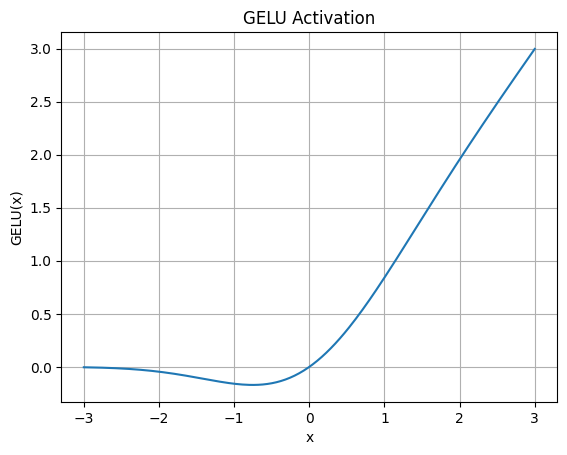

In [50]:
import torch
import matplotlib.pyplot as plt

class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

gelu = GELU()
x = torch.linspace(-3, 3, 200)
y = gelu(x)

plt.plot(x.numpy(), y.detach().numpy())
plt.grid()
plt.title("GELU Activation")
plt.xlabel("x")
plt.ylabel("GELU(x)")
plt.show()

In [51]:
GPT_config = {
    "vocab_size"     : tokenizer_tik.n_vocab, # 50257
    "context_length" : 1024,                  # The maximum number of tokens the model can process at once
    "embedding_dim"  : 768,                   # The number of features used to represent each token 
    "n_heads"        : 12,
    "n_layers"       : 12,                    # How many transformer blocks
    "drop_rate"      : 0.1,
    "qkv_bias"       : False
}

In [52]:
class Feedforward(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = torch.nn.Sequential(
                      torch.nn.Linear(cfg["embedding_dim"], 4*cfg["embedding_dim"]),
                      GELU(),
                      torch.nn.Linear(4*cfg["embedding_dim"], cfg["embedding_dim"])
                    )
    def forward(self, x):
        return self.layers(x)
    
ffn = Feedforward(GPT_config)
ffn(torch.rand(5, GPT_config["embedding_dim"])).shape

torch.Size([5, 768])

In [53]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.attn = MutliHeadAttention(
            d_in           = cfg["embedding_dim"],
            d_out          = cfg["embedding_dim"],
            context_length = cfg["context_length"],
            num_heads      = cfg["n_heads"],
            dropout        = cfg["drop_rate"],
            qkv_bias       = cfg["qkv_bias"]
        ) 

        self.ff    = Feedforward(cfg)
        self.norm1 = LayerNorm(cfg["embedding_dim"])
        self.norm2 = LayerNorm(cfg["embedding_dim"])
        self.dropout_shortcut = torch.nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Attention block
        x_residual = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.dropout_shortcut(x)
        
        x = x_residual + x   

        # Feedforward block
        x_residual = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout_shortcut(x)
        x = x_residual + x   

        return x
    
tb = TransformerBlock(GPT_config)
tb(torch.rand(2, 4, 768)).shape


torch.Size([2, 4, 768])

In [54]:
GPT_config

{'vocab_size': 50257,
 'context_length': 1024,
 'embedding_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [55]:
class GPTModel(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.token_embedding    = torch.nn.Embedding(cfg["vocab_size"], cfg["embedding_dim"])
        self.position_embedding = torch.nn.Embedding(cfg["context_length"], cfg["embedding_dim"])
        self.drop_emb = torch.nn.Dropout(cfg["drop_rate"])

        self.transformer_blocks = torch.nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["embedding_dim"])
        self.out_head   = torch.nn.Linear(cfg["embedding_dim"], cfg["vocab_size"], bias = False)

    def forward(self, in_idx):
        batch_size, seq_length = in_idx.shape
        toks_embeds = self.token_embedding(in_idx)
        pos_embeds  = self.position_embedding(torch.arange(0, seq_length, device = in_idx.device))

        x = toks_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits



In [56]:
text_1 = "hope this works"
text_2 = "this works well lol"

sample_encoded = torch.tensor([tokenizer_tik.encode(text_1), tokenizer_tik.encode(text_2)])
sample_encoded

tensor([[   71,  3008,   428,  2499],
        [ 5661,  2499,   880, 19462]])

In [57]:
model = GPTModel(GPT_config)
out = model(sample_encoded)
out.shape

torch.Size([2, 4, 50257])

In [58]:
total_param = sum(p.numel() for p in model. parameters())
print(f"{total_param:,}")

163,009,536


In [59]:
# inferencing

def generate_text_simple(model, tokens, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        tokens = tokens[:, -context_size:] # just in case it overflows
        logits = model(tokens)
        logits = logits[:, -1, :] # last context vector
        idx_next = torch.argmax(torch.softmax(logits, dim = -1), dim = -1, keepdim=True)
        tokens = torch.cat((tokens, idx_next), dim = 1)
    return tokens

In [60]:
text = "hello how are you"
tokens = tokenizer_tik.encode(text)
tokens = torch.tensor(tokens).unsqueeze(0)
model = GPTModel(GPT_config)

generated_text = generate_text_simple(model = model, tokens = tokens, max_new_tokens = 6, context_size = GPT_config["context_length"])

decoded = tokenizer_tik.decode(generated_text.tolist()[0])
decoded

'hello how are you PI TVs RPC deities exoner579'

In [61]:
def text_to_token_ids(text, tokenizer):
    # return torch.tensor(tokenizer.encode(text, allowed_special="<|endoftext|>")).unsqueeze(0)

    return torch.tensor(
                tokenizer.encode(
                        text,
                        allowed_special={"<|endoftext|>"}
                    )
            ).unsqueeze(0)

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())
    
token_ids_to_text(text_to_token_ids("hello how are you", tokenizer_tik), tokenizer_tik)

'hello how are you'

In [62]:
# Loss functions

inputs = torch.tensor([
    [16833,  3626, 6100],   # "every effort moves"
    [   40,  1107,  588]    # "I really like"
])

targets = torch.tensor([
    [ 3626, 6100,  345],    # "effort moves you"
    [ 1107,  588, 11311]    # "really like chocolate"
])

print("inputs:\n", inputs)
print("targets:\n", targets)

inputs:
 tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])
targets:
 tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])


In [63]:
with torch.no_grad():
    logits = model(inputs)
logits.shape

torch.Size([2, 3, 50257])

In [64]:
# logits to probabilities

probs = torch.softmax(logits, dim = -1)
probs.shape

torch.Size([2, 3, 50257])

In [65]:
probs.sum(dim = -1, keepdim=True)

tensor([[[1.0000],
         [1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000],
         [1.0000]]])

In [66]:
predicted_token_ids = torch.argmax(probs, dim = -1, keepdim=True)
predicted_token_ids

tensor([[[49782],
         [37292],
         [24669]],

        [[44976],
         [20264],
         [19416]]])

In [67]:
print (f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer_tik)}") 
print (f"Outputs batch 1: {token_ids_to_text(predicted_token_ids[0]. flatten(), tokenizer_tik) }")

Targets batch 1:  effort moves you
Outputs batch 1: geist CAD467


In [68]:
example_idx = 0
probs[example_idx, [0, 1, 2], targets[example_idx]]

tensor([1.9898e-05, 1.9313e-05, 1.3157e-05])

In [69]:
token_ids_to_text(targets[example_idx], tokenizer_tik)

' effort moves you'

In [70]:
# Cross entropy loss

probs = torch.softmax(logits, dim = -1)


example_idx = 0
probs_1 = probs[example_idx, [0, 1, 2], targets[example_idx]]
example_idx = 1
probs_2 = probs[example_idx, [0, 1, 2], targets[example_idx]]

probs_cat = torch.cat((probs_1, probs_2), dim = 0)
log_probs = torch.log(probs_cat)
-1 * log_probs.mean()

tensor(11.0636)

In [71]:
logits_flat = logits.flatten(0,1)
logits_flat.shape

torch.Size([6, 50257])

In [72]:
targets_flat = targets.flatten(0,1)
targets_flat.shape

torch.Size([6])

In [73]:
torch.nn.functional.cross_entropy(logits_flat, targets_flat)

tensor(11.0636)

In [74]:
## getting training / val data ready
print(raw_text[:100])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g


In [75]:
train_ratio = 0.90
split_idx = int(len(raw_text) * train_ratio)
train_data = raw_text[:split_idx]
val_data   = raw_text[split_idx:]

In [76]:
val_data

'ue\' collapsed like a house of cards. He didn\'t sneer, you understand, poor Stroud--he just lay there quietly watching, and on his lips, through the gray beard, I seemed to hear the question: \'Are you sure you know where you\'re coming out?\'\n\n"If I could have painted that face, with that question on it, I should have done a great thing. The next greatest thing was to see that I couldn\'t--and that grace was given me. But, oh, at that minute, Rickham, was there anything on earth I wouldn\'t have given to have Stroud alive before me, and to hear him say: \'It\'s not too late--I\'ll show you how\'?\n\n"It _was_ too late--it would have been, even if he\'d been alive. I packed up my traps, and went down and told Mrs. Stroud. Of course I didn\'t tell her _that_--it would have been Greek to her. I simply said I couldn\'t paint him, that I was too moved. She rather liked the idea--she\'s so romantic! It was that that made her give me the donkey. But she was terribly upset at not getting 

In [77]:
GPT_config["context_length"] = 256 # for simplicity
GPT_config

{'vocab_size': 50257,
 'context_length': 256,
 'embedding_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [78]:
train_dataloader = create_dataloader(
    text        = train_data, 
    max_length  = GPT_config["context_length"], 
    stride      = GPT_config["context_length"], 
    num_workers = 0, 
    batch_size  = 2,
    shuffle     = True,
    drop_last   = True
    )

val_dataloader = create_dataloader(
    text        = val_data, 
    max_length  = GPT_config["context_length"], 
    stride      = GPT_config["context_length"], 
    num_workers = 0, 
    batch_size  = 2,
    shuffle     = False,
    drop_last   = True
    )


sample_inputs, sample_targets = next(iter(train_dataloader))
sample_inputs.shape

torch.Size([2, 256])

In [79]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    return torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten(0,1)) # loss

def calc_loss_loader(dataloader, model, device, num_batches = None):
    if len(dataloader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len (dataloader))

    total_loss = 0
    for idx, (input_batch, target_batch) in enumerate(dataloader):
        if idx < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else: break
    return total_loss / num_batches

In [80]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_dataloader, model, device = "cpu")
    val_loss = calc_loss_loader(val_dataloader, model, device = "cpu")
    
print(f"Train loss: {train_loss:.4f}")
print(f"Val loss: {val_loss:.4f}")

Train loss: 10.9706
Val loss: 10.9614


In [81]:
# text = "hello how are you"
# tokens = tokenizer_tik.encode(text)
# tokens = torch.tensor(tokens).unsqueeze(0)
# model = GPTModel(GPT_config)

# generated_text = generate_text_simple(model = model, tokens = tokens, max_new_tokens = 6, context_size = GPT_config["context_length"])

# decoded = tokenizer_tik.decode(generated_text.tolist()[0])
# decoded

def generate_and_print_samples(model, tokenizer, device, start_context, max_new_tokens = 50):
    model.eval()
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        generated_ids = generate_text_simple(model = model, tokens = encoded, max_new_tokens = max_new_tokens, context_size = GPT_config["context_length"])
    decoded = token_ids_to_text(generated_ids, tokenizer)
    print(decoded.replace("\n", " ")) # compacting
    model.train()

generate_and_print_samples(model = model,
                           tokenizer = tokenizer_tik, device="cpu", start_context = "hello", max_new_tokens=50)

hello recounted outpost Cinnamon pieces Indigoiliesguridelity constructing blindness ensemble Rosenberg NPCsoing Quincy differenceords Breath478 ensemble peeled Amb absenceTrivia�bill77qv bite somebodyivasqv gunshot blinked Richie Acts Zimmer Theodore Comput Sure valiant Imm historical STATE universally issues rotor accepting reactiverating


In [ ]:
def train_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_itter, start_context, tokenizer, verbose = True, max_new_tokens = 50):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for idx, (input_batch, target_batch) in enumerate(train_loader):
            optimizer.zero_grad()

            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            optimizer.step()
            tokens_seen = input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                model.eval()
                with torch.no_grad():
                    train_loss = calc_loss_loader(train_loader, model, device = device, num_batches = eval_itter)
                    val_loss   = calc_loss_loader(val_loader, model, device = device, num_batches = eval_itter)
                model.train()
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                        f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                    )
                
        # print some samples
        if verbose:
            generate_and_print_samples(model = model,
                           tokenizer = tokenizer, device = device, start_context = start_context, max_new_tokens = max_new_tokens)
    return train_losses, val_losses, track_tokens_seen

In [88]:
torch.manual_seed(123)

device = "cpu"
model = GPTModel(GPT_config)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)


train_losses, val_losses, track_tokens_seen = train_simple(model         = model, 
                                                           train_loader  = train_dataloader,
                                                           val_loader    = val_dataloader,
                                                           optimizer     = optimizer,
                                                           device        = device,
                                                           num_epochs    = 10,
                                                           eval_freq     = 5,
                                                           eval_itter    = 5,
                                                           start_context = "Every effort moves you", 
                                                           tokenizer     = tokenizer_tik,
                                                           )


Ep 1 (Step 000000): Train loss 9.899, Val loss 10.005
Ep 1 (Step 000005): Train loss 8.157, Val loss 8.376
Every effort moves you,.                                                
Ep 2 (Step 000010): Train loss 6.692, Val loss 7.066
Ep 2 (Step 000015): Train loss 5.992, Val loss 6.621
Every effort moves you, and,, and, and,,,,, and, and,,,, and,,,, and, and,, and,,,, and,, and,,, and, and,,,,,,
Ep 3 (Step 000020): Train loss 5.776, Val loss 6.516
Ep 3 (Step 000025): Train loss 10.840, Val loss 12.039
Every effort moves you, and I had the the of the the the the of the the. I had the-- the of the the of the of the to the the, and the the to the the of the of the the of the the of the of the of
Ep 4 (Step 000030): Train loss 5.339, Val loss 6.365
Ep 4 (Step 000035): Train loss 5.102, Val loss 6.368
Every effort moves you--"I a"I a"I--and, and the"--and, and he was, and he was.  "I, and the of the of the   "I of theis, and he was,
Ep 5 (Step 000040): Train loss 4.795, Val loss 6.301
Every 

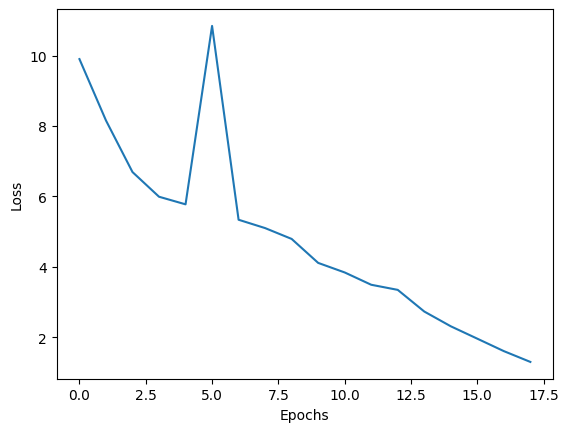

In [123]:
plt.plot(train_losses, label = "train loss")
# plt.plot(val_losses, label = "val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [130]:
generate_and_print_samples(model = model,
                           tokenizer = tokenizer_tik, 
                           device="cpu", 
                           start_context = "every effort moves you", 
                           max_new_tokens=50)

every effort moves you know," was one of the picture for nothing--I told Mrs.  "Once, when I looked up, I felt to see a smile behind his pictures.  "Oh, I saw that, and down the room, when I


In [132]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, "checkpoint_10_epochs.pt")

In [ ]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# model(x)
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [29]:
def print_sampled_tokens(probas):
    # torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

49 x closer
0 x every
0 x effort
580 x forward
7 x inches
0 x moves
1 x pizza
360 x toward
3 x you


In [31]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
scaled_probas

[tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
         1.0120e-04, 3.5758e-01, 4.0122e-03]),
 tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
         2.9718e-38, 9.0133e-03, 2.8514e-22]),
 tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])]

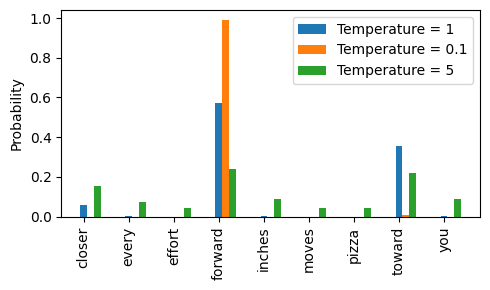

In [33]:
import matplotlib.pyplot as plt
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [45]:
print_sampled_tokens(scaled_probas[-1])

172 x closer
75 x every
39 x effort
253 x forward
75 x inches
41 x moves
44 x pizza
213 x toward
88 x you
